In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

# Target Orbit Env

### Problem: 
What is the policy that allows you to stay above the surface of the circular 2-D planet for as long as possible as near as possible to the target altitude with expending the least amount of energy (making actions).

### The Math:
For the 2D circular problem, we're solving a physics problem described by the Lagrangian,

$\mathcal{L} = \frac{1}{2}(\dot{r}^2+r^2 \dot{\theta}^2) + \frac{GM}{r}$ 

To make the problem accessable via computation, we choose a natural set of units such that,

$GM = 1 \ ln^3/tn^2$, $R_{\rm planet} = 1 \ ln$

where $ln$ is a "natural length" and $tn$ is a "natural time" for the problem. The solution to the Lagrangian minimization problem gives the differential equation sets below.

$\frac{d}{dt}\left(\frac{d \mathcal{L}}{d\dot{r}}\right) = \frac{d \mathcal{L}}{dr} \rightarrow \ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2}$

$\frac{d}{dt}\left(\frac{d \mathcal{L}}{d\dot{\theta}}\right) = \frac{d \mathcal{L}}{d\theta} \rightarrow \frac{d}{dt}\left(r^2 \dot{\theta} \right) = 0 \rightarrow  \ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$ 

### Example Unit Converstion:
Let's look at an example to understand the natural units of the problem, ie we'll use the radius of the Earth as the natural length, and the mass of the Earth as our planet mass.

$1 \ ln = 6 \times 10^6 \ m$

$GM = \left(6.67 \times 10^{-11} \ \frac{m^3}{kg \ s^2} \right) * \left(6 \times 10^{24} \ kg \right) = \left(4 \times 10^{14} \ \frac{m^3}{s^2} \right)* \left(1 \ \frac{ln}{6 \times 10^6 \ m} \right)^3 \left(X \ \frac{s}{tn} \right)^2 = 1 \ \frac{ln^3}{tn^2}$

$\left(1.85 \times 10^{-6} \right) \ X^2 = 1 \rightarrow X = 734.66$

$1 \ s = 0.0013 \ tn$


### Reward Conditions:
What is the reward function for this problem?

One we want to reward the agent for each step of staying above the surface, and end the episode upon contact with the surface.

$r(s,a) = FR$ if $r > 1.0 \ ln$, where $FR > 0$ is the flight reward.

We want the agent to get as close to the target altitute as possible so a penality function is appropriate when the agent isn't at the target altitute.

$r(s,a) = -\lambda_t ||r - R_t||_n$

where $\lambda_t > 0$ is the importance of how rapidly the agent should get to the altitude, as well we have $n$ which we dont know if the L2 or L1 norm is best for this problem.

We also need to penalize the agent for making any actions at all, ie rotating the vehicle orientation or firing the main engine.  It doesn't make much sense for the same energy expenditure for firing the main engine vs changing the agent's oreientation, so we will have main engine penality $ME$ and orientation penality $OP$, such that our final reward function looks like.


$r(s,a) = FR -\lambda_t ||r - R_t||_n - ME(a) - OP(a)$

### Giving our Agent a Hint:
It could take a very long time for the agent to randomly find the optimal trajectory so we can do two things to help our agent find what we're looking for more rapidly. 

1) We can pretrain our agent with a simple policy that has the agent rotating more tangentially to the surface of the planet as it asscends.

2) We can add another penality term to the reward that penalizes the agent not having an the correct orbital angular velocity for the selected target altitude.


Circular orbital velocity in natural units:

$\ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2} = 0$

$\dot{\theta} = R_t^{-3/2}$

And how long is a circular orbtial period in natural units?

$T = \frac{2\pi}{\dot{\theta}} = 2\pi R_t^{3/2}$

We can use this time to stop the episode if the time running is exceedingly longer than this measure.

### Example:
If the target altitude is $R_t = 2 \ ln$ then how long is the orbital period?

$T = 17.8 \ tn = 3.6 \ hrs$

If we use time steps of $dt = 1 \ s$ then the orbital period will be completed in,

$T/dt = 17.8 \ tn / (1 tn/736.66 s) / (1s/step) =  13,113$ steps

This gives you an idea of how to limit the simulation epsiodes. On one hand we want high frequency policy control updates, on the other we want our episodes to be as few steps as possible, this leads to the other possible way of constraining the episode length in terms of max steps ($MS$) can imply the time step in the simulation.

$MS = 100 \rightarrow 100 = 13113/(x \ s/ step) \rightarrow 1 \ step = 131.13 \ s$

The general expression is

$MS =2 \pi R_t^{3/2}/(1 \ tn/X \ s) / ( x \ s/step)$

Where $X = (R_t^3/GM)^{1/2}$ in SI units, and $R_t$ below is in natural units.

$ (2 \pi R_t^{3/2})*X/MS \ s = 1 \ step$

In [2]:
X = ((6*10**6)**3/(6.674*10**(-11)*6*10**(24)))**0.5
MS = 5000
print('seconds per step: ', (2*np.pi*2**1.5)*X/MS)

seconds per step:  2.6104357394519746


## Solving the System of Equations

$\ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2}$

$\ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$ 

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

$y_2 = \theta$

$y_3 = \dot{\theta}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 = y_0 y_3^2 - \frac{1}{y_0^2}$

$\dot{y}_2 = y_3$

$\dot{y}_3 = -2 \frac{y_1}{y_0} y_3$ 

### RK4 Algorithm


In [26]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, planet_Mass_kg = 5.972*10**(24), planet_R_km = 6371.0, 
                 dt_s = 1.0, target_alt = 2.0, thrust_gs= 1.5, verbose = False, 
                 record_history = True, record_rate = 100):
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, 0]), 
                                           high=np.array([2*np.pi, 10**3]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0,0,0]), 
                                                high=np.array([10**9,10**9,2*np.pi,10**9]), 
                                                dtype=np.float64)
        
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        
        # Convert to Natural Problem Units
        # tn_s = (R^3/GM)^1/2 -- where all measures are in SI units
        planet_R_m = planet_R_km*10**3
        tn_s = (planet_R_m**3/(G*planet_Mass_kg))**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = planet_R_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1.0/planet_R_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_alt = target_alt
        
        # solving the oribital angular velocity in natural units
        self.oribit_theta_dot = target_alt**(-1.5)
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi*target_alt**(1.5)
        # adding in a buffer to allow it to go a little longer
        self.max_time = self.max_time*1.5
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.oribit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
        
        # Choosing how strong the penalty factors will be for taking actions
        self.orientation_penalty = 0.1
        self.thrust_penalty = 10*self.orientation_penalty
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g= (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        self.max_o_thrust = 1.0
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.01
        
        # Translational Coordinates
        self.r = 1.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), self.orientation_angle]])
        
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # start off with an impulse to get off the ground
        #obs, reward, done, _ = self.step(2)
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0], 0.0, self.max_thrust)
        orientation_thrust = np.clip(action[1], -self.max_o_thrust, self.max_o_thrust)
        
        self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        self.orientation_rate += orientation_thrust*self.dt 
        
        # Translating the actions into the planet centric coordinate system
        action_vector = thrust*np.array([np.cos(self.orientation_angle), 
                                         np.sin(self.orientation_angle)])
        
        #print('action v: ', action_vector)
        
        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        #print('r_vect: ', r_vect)
        #print(action_along_r)
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = self.r*self.r_dot**2 - 1./self.r**2 + action_along_r
        y2_k1 = self.theta_dot
        y3_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = (self.r + y0_k1*self.dt/2)*(self.r_dot + y1_k1*self.dt/2)**2 - 1./(self.r + y0_k1*self.dt/2)**2 + action_along_r
        y2_k2 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k2 = -2.0*(self.r_dot + y1_k1*self.dt/2)/(self.r + y0_k1*self.dt/2)*(self.theta_dot + y3_k1*self.dt/2) + action_along_theta
        
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = (self.r + y0_k2*self.dt/2)*(self.r_dot + y1_k2*self.dt/2)**2 - 1./(self.r + y0_k2*self.dt/2)**2 + action_along_r
        y2_k3 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k3 = -2.0*(self.r_dot + y1_k2*self.dt/2)/(self.r + y0_k2*self.dt/2)*(self.theta_dot + y3_k2*self.dt/2) + action_along_theta
        
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = (self.r + y0_k3*self.dt)*(self.r_dot + y1_k3*self.dt)**2 - 1./(self.r + y0_k3*self.dt)**2 + action_along_r
        y2_k4 = (self.theta_dot + y3_k1*self.dt/2)
        y3_k4 = -2.0*(self.r_dot + y1_k2*self.dt/2)/(self.r + y0_k2*self.dt/2)*(self.theta_dot + y3_k2*self.dt) + action_along_theta
        
        
        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)

        self.theta = self.theta + self.dt/6*(y2_k1 + 2*y2_k2 + 2*y2_k3 + y2_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(y3_k1 + 2*y3_k2 + 2*y3_k3 + y3_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # reward 1 for every step not done, encouraging orbit seeking
        # penalty for every step not near the target altitude
        reward = (1.0 + 
                  - 0.00*thrust/self.max_thrust 
                  - 0.0*np.abs(orientation_thrust)/self.max_o_thrust -
                  0.0*np.abs(self.target_alt - self.r)/self.target_alt - 
                  0.0*np.abs(self.oribit_theta_dot - self.theta_dot)/self.oribit_theta_dot)
        
        # set if at the terminal state
        done = False
        
        # test for terminal state
        if ((self.r <= 1.0) | 
            (self.r > self.target_alt*3.0) | 
            (self.elapsed_time > self.max_time*2.0)):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-1,1,100,endpoint=True)
        plt.plot(x, np.sqrt(1-x**2), c='k')
        plt.plot(x,-np.sqrt(1-x**2), c ='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        N = (sample_traj_rate-1)+10
        xaxis_orientation = self.trajectory[::N,2]
        # vector terminal pts
        start_pts = self.trajectory[::N,[0,1]]
        end_pts = start_pts + 0.05*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

## Example Policy

In [189]:
env = OrbitalDynamicsEnv(dt_s = 0.1, verbose=True, target_alt = 1.75)

Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.00012414853327976584
	target theta dot:  0.4319593977248311  1/tn
	max allowable natural time:  21.818666315423467  tn =  17574.646867760905  s
	max allowed steps:  175747
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2


In [27]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)[0]
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

In [28]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [29]:
HID_SIZE = 128

class ModelA2C(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelA2C, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(HID_SIZE, act_size),
            nn.Tanh(),
        )
        self.var = nn.Sequential(
            nn.Linear(HID_SIZE, act_size),
            nn.Softplus(),
        )
        self.value = nn.Linear(HID_SIZE, 1)

    def forward(self, x):
        base_out = self.base(x)
        return self.mu(base_out), self.var(base_out), \
               self.value(base_out)
    
    
class TestNet(nn.Module):
    def __init__(self, obs_size, act_size):
        super(TestNet, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
        )
        self.value = nn.Linear(HID_SIZE, 1)
        
        self.go_up_v = torch.FloatTensor([[1.1, 0.0]])
        self.go_up_var_v = torch.FloatTensor([[0.001, 0.001]])

    def forward(self, x):
        base_out = self.base(x)
        return self.go_up_v, self.go_up_var_v, self.value(base_out)

In [30]:
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        return actions, agent_states

In [31]:
def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)[2]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = OrbitalDynamicsEnv(dt_s = 0.1, verbose=True, target_alt = 1.75, record_history = False)
test_env = OrbitalDynamicsEnv(dt_s = 0.1, verbose=True, target_alt = 1.75, record_rate = 1)

agent = AgentA2C(net, device=device)

net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
up_net = TestNet(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
print(net)

Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.00012414853327976584
	target theta dot:  0.4319593977248311  1/tn
	max allowable natural time:  21.818666315423467  tn =  17574.646867760905  s
	max allowed steps:  175747
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2
Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.00012414853327976584
	target theta dot:  0.4319593977248311  1/tn
	max allowable natural time:  21.818666315423467  tn =  17574.646867760905  s
	max allowed steps:  175747
Policy Parameters
-----
	Discrete thrust acceleration:  1.5  ln/tn^2 =  14.729298049223939  m/s^2
ModelA2C(
  (base): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (mu): Sequential(
    (0): Linea

### Test Net Is Neutral

In [33]:
s = env.reset()
s_v = torch.FloatTensor([s])
net(s_v)

(tensor([[0.0090, 0.1143]], grad_fn=<TanhBackward>),
 tensor([[0.7673, 0.6558]], grad_fn=<SoftplusBackward>),
 tensor([[0.0520]], grad_fn=<AddmmBackward>))

In [34]:
agent(s_v,None)

(array([[ 1.94878997, -1.23594642]]), None)

In [35]:
up_net(s_v)

(tensor([[1.1000, 0.0000]]),
 tensor([[0.0010, 0.0010]]),
 tensor([[0.3045]], grad_fn=<AddmmBackward>))

### Pretrain so that we have good initial settings (the mentor)

In [36]:
net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)

go_thrust_v = torch.FloatTensor([[env.max_thrust, 0.0]])

# this pumps the variance parameters so we start off with high exploration
for _ in range(500):
    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(s_v)
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v =  0.0*ent_v.mean()
    mu_loss_v = ((mu_v - go_thrust_v)**2).mean()
    
    loss_v = mu_loss_v + entropy_loss_v
    
    loss_v.backward()
    optimizer.step()

In [37]:
s = env.reset()
s_v = torch.FloatTensor([s])
net(s_v)

(tensor([[9.9991e-01, 1.5348e-06]], grad_fn=<TanhBackward>),
 tensor([[0.7172, 0.7582]], grad_fn=<SoftplusBackward>),
 tensor([[-0.0210]], grad_fn=<AddmmBackward>))

In [38]:
GAMMA = 0.99
REWARD_STEPS = 2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
ENTROPY_BETA = 1e-5

TEST_ITERS = 5000

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, GAMMA, 
                                                       steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

batch = []
best_reward = None

#reward_100 = collections.deque(maxlen=100)
    
for step_idx, exp in enumerate(exp_source):
    rewards_steps = exp_source.pop_rewards_steps()
    if rewards_steps:
        rewards, steps = zip(*rewards_steps)
        #reward_100.append(rewards[0])

    if step_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(net, test_env, device=device)
        print("Test done is %.2f sec, reward %.3f, steps %d" %\
              (time.time() - ts, rewards, steps))
        #writer.add_scalar("test_reward", rewards, step_idx)
        #writer.add_scalar("test_steps", steps, step_idx)
        if (best_reward is None) or (best_reward < rewards):
            if best_reward is not None:
                print("Best reward updated: %.8f -> %.8f" % (best_reward, rewards))
            best_reward = rewards

    batch.append(exp)
    if len(batch) < BATCH_SIZE:
        continue

    states_v, actions_v, vals_ref_v = unpack_batch_a2c(batch, net, device=device,
                                                       last_val_gamma=GAMMA**REWARD_STEPS)
    batch.clear()

    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

    adv_v = vals_ref_v.unsqueeze(dim=-1) - value_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, actions_v)
    loss_policy_v = -log_prob_v.mean()
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()
    
    mentor_loss_v = ((mu_v - go_thrust_v)**2).mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v + mentor_loss_v
    loss_v.backward()
    optimizer.step()

Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.00 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done is 0.01 sec, reward 1.000, steps 1
Test done 

KeyboardInterrupt: 

In [39]:
s = env.reset()
s_v = torch.FloatTensor([s])
net(s_v)

(tensor([[1.0000, 0.0249]], grad_fn=<TanhBackward>),
 tensor([[8.4198e-04, 1.4417e+00]], grad_fn=<SoftplusBackward>),
 tensor([[1.3814]], grad_fn=<AddmmBackward>))

In [40]:
#test_net(net, test_env, count=1)
test_net(up_net, test_env, count=1)

KeyboardInterrupt: 

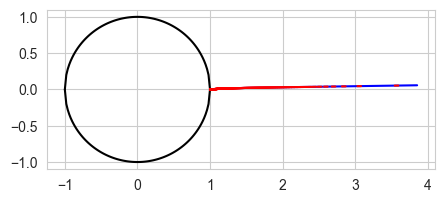

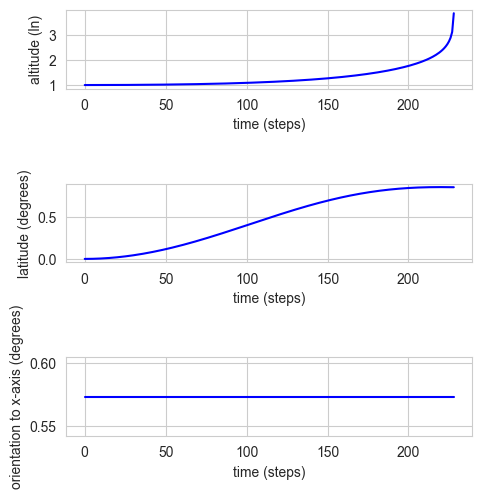

In [25]:
sns.set_style('whitegrid')
test_env.render(sample_traj_rate=100)

## Vanilla Policy Gradient Method

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 128

class PGN(nn.Module):
    def __init__(self, in_size):
        super(PGN,self).__init__()
        
        self.actions_mu = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
        
        self.values =  nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def __call__(self, x):
        return self.actions_mu(x), self.actions_var(x), self.values(x)
    
policy_net = PGN(4).to(device)

policy_net

using device:  cpu


PGN(
  (actions_mu): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (actions_var): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (values): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [149]:
ridx = np.random.choice(range(len(traj_s)),size = 1000)
states_v = torch.FloatTensor(np.array(traj_s)[ridx])
actions_v = torch.LongTensor(np.array(traj_a)[ridx])
#actions_v = torch.eye(4)[traj_a]

In [178]:
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [152]:
for e in range(5000):
    optimizer.zero_grad()
    mu_v, var_v, _ = policy_net(states_v)
    
    loss_v = ((mu_v - actions_v)**2).mean()
    loss_v.backward()
    optimizer.step()
    
    if e % 100 == 0:
        print(loss_v.item())

0.611042857170105
0.07870986312627792
0.04247419536113739
0.029623961076140404
0.0246701892465353
0.022615090012550354
0.021483683958649635
0.020682865753769875
0.01997537910938263
0.019331539049744606
0.01875515654683113
0.018252111971378326
0.017818685621023178
0.01744617521762848
0.01712161675095558
0.016824597492814064
0.01656264252960682
0.01633056439459324
0.016125833615660667
0.015943657606840134
0.015776731073856354
0.015621383674442768
0.015472836792469025
0.015327652916312218
0.01518517266958952
0.015045098960399628
0.01490660198032856
0.01477011013776064
0.014637439511716366
0.014506872743368149
0.014379916712641716
0.014262971468269825
0.014149095863103867
0.014043898321688175
0.013938740827143192
0.01384030096232891
0.013742691837251186
0.013647002167999744
0.013478003442287445
0.013384887017309666
0.013283448293805122
0.013193108141422272
0.013111486099660397
0.01303156465291977
0.012958995997905731
0.012887602671980858
0.012806102633476257
0.012738815508782864
0.01267056

In [162]:
state = env.reset()
episode_R = 0.0

while True:
    state_v = torch.FloatTensor([state])
    mu_v, var_v, _ = policy_net(state_v)
    mu = mu_v.data.cpu().numpy()[0]
    
    state, reward, is_done, _ = env.step(mu)
    episode_R += reward
    if is_done:
        break

In [163]:
episode_R

-631.6050344747143

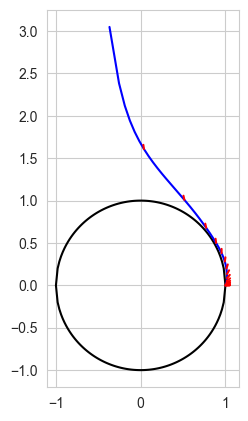

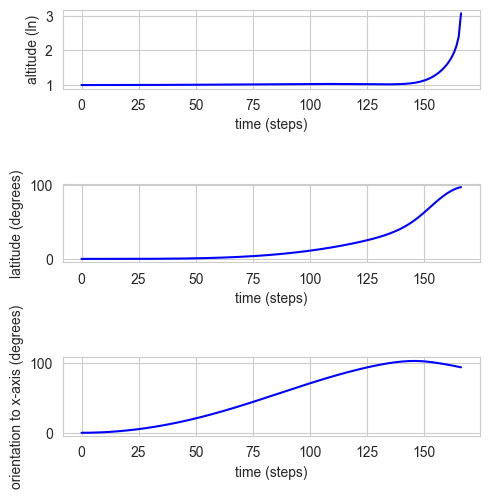

In [164]:
sns.set_style('whitegrid')
env.render()

In [171]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

tensor([[-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209]], grad_fn=<AddBackward0>)


RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

-1572.8280186113989 4055.6625553967274


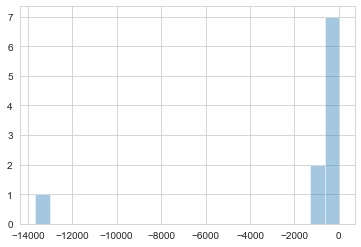

In [174]:
print(np.mean(total_rewards), np.std(total_rewards))
sns.distplot(total_rewards,kde=False);

Episode Reward:  -1105.2090478697733


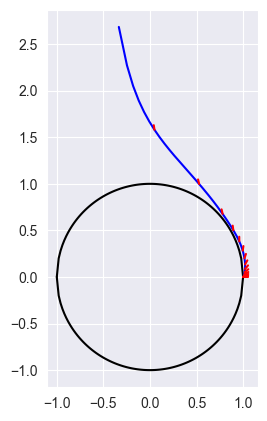

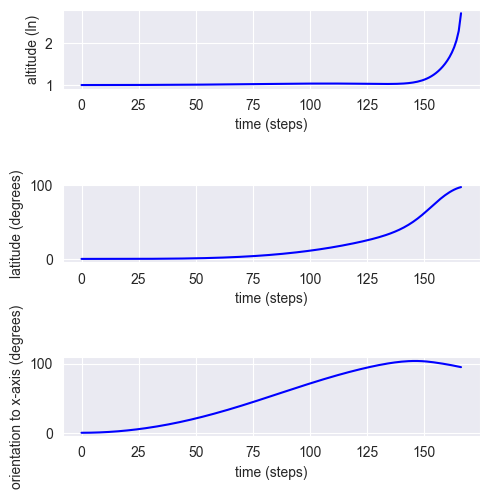

In [176]:
s = env.reset()

episode_reward = 0.0

program_cmd_history = []

done = False
while not done:
    s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
    mu_v, var_v, _ = policy_net(s_v)
    mu = mu_v.data.cpu().numpy()
    var = var_v.data.cpu().numpy()
    a = [np.random.normal(loc=mu[0,0],scale=np.abs(var[0,0])),
         np.random.normal(loc=mu[0,1],scale=np.abs(var[0,1]))]

    program_cmd_history.append(a)    
    s, r, done,_ = env.step(a)
    episode_reward +=r

print('Episode Reward: ', episode_reward)
sns.set_style('darkgrid')
env.render()

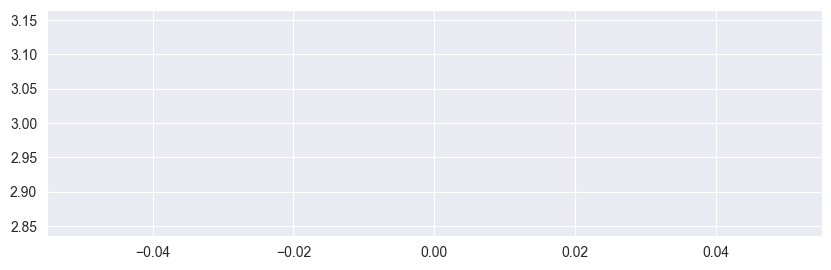

In [95]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(program_cmd_history);